# Exercise 8
## Time Series Analysis & Recurrent Neural Networks, SoSe 2021
### Author: Elias Olofsson
    Version information:
        2021-06-16: v.1.0. First public release. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.rc('image', cmap='gray')

import torch as tc
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Notebook graphics settings: 
%config InlineBackend.figure_format = 'svg' # inline graphics (options: 'svg', 'png', 'retina', etc.)
plt.rcParams['figure.dpi'] = 200            # custom dpi setting for inline png:s

## Task 1: Learning Dynamics

(21, 1)


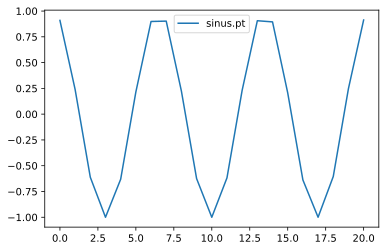

In [2]:
input_size  = 1
hidden_size = 10 # CHOOSE HYPER-PARAM
output_size = 1
#epochs = 20

data = tc.load('sinus.pt')
print(data.shape)

plt.plot(data, label='sinus.pt')
plt.legend()
plt.show()

x = tc.FloatTensor(data[:-1]) # x_t
y = tc.FloatTensor(data[1:])  # x_t+1

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if tc.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, init=None):
        super(RNN, self).__init__()
        # define the network modules here
        # e.g. self.layer = nn.Linear(6, 5)
        self.lat_model = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Tanh()
        )
        self.obs_model = nn.Linear(hidden_size, input_size)
        
        if init == 'normal':            
            tc.nn.init.normal_(self.lat_model[0].weight)
            #tc.nn.init.normal_(self.obs_model.weight)
        elif init == 'uniform':
            tc.nn.init.uniform_(self.lat_model[0].weight)
            #tc.nn.init.uniform_(self.obs_model.weight)
        elif init == 'orthogonal':
            tc.nn.init.orthogonal_(self.lat_model[0].weight)
            #tc.nn.init.orthogonal_(self.obs_model.weight)
        elif init == 'xavier_uniform':
            tc.nn.init.xavier_uniform_(self.lat_model[0].weight)
        

    def forward(self, inp, hidden):
        # instantiate modules here
        # e.g. output = self.layer(inp)
        xz = tc.cat((inp, hidden), dim=1)
        hidden = self.lat_model(xz)
        output = self.obs_model(hidden)
        return output, hidden

Using cpu device


In [4]:
def train(model, optimizer):
    """Train for a single epoch
    """
    hidden = tc.zeros((1, hidden_size))
    tot_loss = 0
    optimizer.zero_grad()
    for j in range(x.size(0)):
        input_ = x[j:(j+1)].to(device)
        target = y[j:(j+1)].to(device)
        (prediction, hidden) = model.forward(input_, hidden)
        loss = (prediction - target).pow(2).sum()/2
        tot_loss += loss
    tot_loss.backward(retain_graph=True)  # retain, because of BPTT (next lecture)
    optimizer.step()
    return tot_loss

In [5]:
def train_model(model, optimizer, epochs=20):
    losses = []    
    for i in range(epochs):
        loss = train(model, optimizer)
        losses.append(loss)
    return losses

In [6]:
def plot_prediction(model, losses, method='SGD', only_prediction=False):
    
    # Generate a prediction time series from the trained model.
    hidden = tc.zeros((1, hidden_size))
    predictions = []
    inp = x[0:1]
    for i in range(6*x.size(0)):  # predict for longer time than the training data
        prediction, hidden = model.forward(inp, hidden)
        inp = prediction
        predictions.append(prediction.data.numpy().ravel()[0])
    # Plotting
    if only_prediction:
        fig, ax = plt.subplots(1, 1)
        ax.plot(data[1:], label='training set')
        ax.plot(predictions, label='predictions')
        ax.set_xlabel('time')
        ax.set_ylabel('scalar value')
        ax.legend()
    else:
        fig, ax = plt.subplots(2, 1)
        ax = ax.flatten()
        ax[0].plot(losses, label='training loss')
        ax[0].set_ylabel('loss')
        ax[0].set_xlabel('epochs')
        ax[0].legend()
    
        ax[1].plot(data[1:], label='training set')
        ax[1].plot(predictions, label='predictions')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('scalar value')
        ax[1].legend()
    
    if only_prediction:
        plt.suptitle(f'Init = {init}, before training')
    else:
        if method == 'SGD':
            plt.suptitle(f'SGD: LR = {lr}, Momentum = {mom}')
        elif method == 'ADAM':
            plt.suptitle(f'ADAM: LR = {lr}, ')
    
    plt.show()

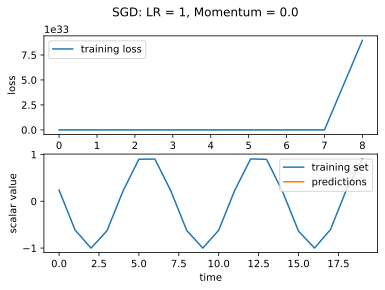

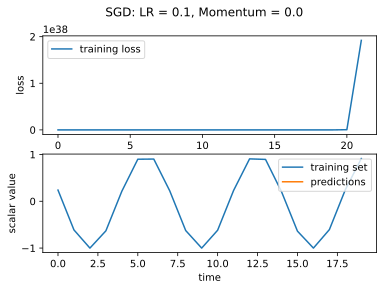

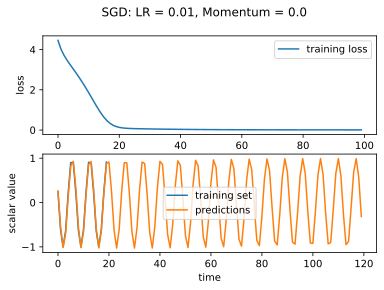

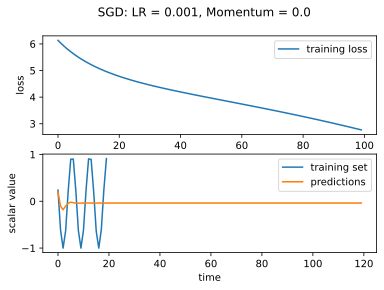

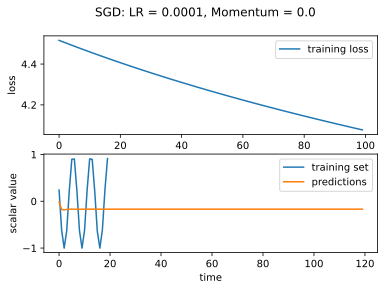

In [7]:
learning_rates = [1, 0.1, 0.01, 0.001, 0.0001]
momentum = [0.0]
for lr in learning_rates:
    for mom in momentum:
        model = RNN(input_size, hidden_size, output_size).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom)
        losses = train_model(model, optimizer, epochs=100)
        plot_prediction(model, losses)

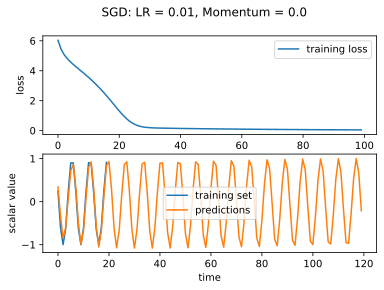

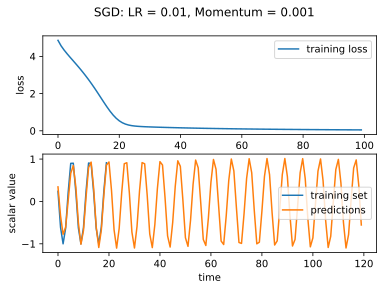

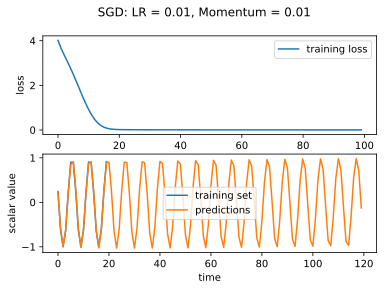

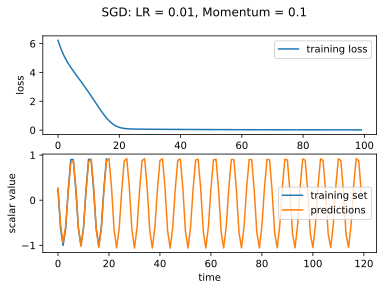

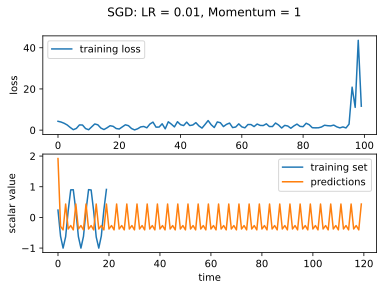

In [8]:
learning_rates = [0.01]
momentum = [0.0, 0.001, 0.01, 0.1, 1]
for lr in learning_rates:
    for mom in momentum:
        model = RNN(input_size, hidden_size, output_size).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom)
        losses = train_model(model, optimizer, epochs=100)
        plot_prediction(model, losses)

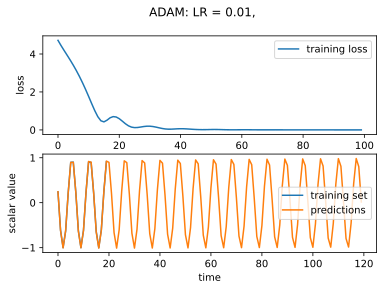

In [9]:
model = RNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
losses = train_model(model, optimizer, epochs=100)
plot_prediction(model, losses, method='ADAM')

# Task 2: Reservior Computing

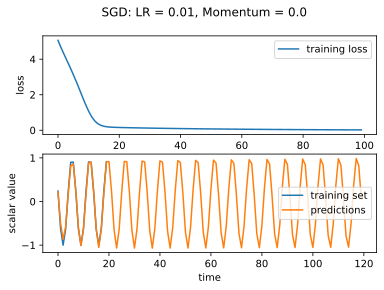

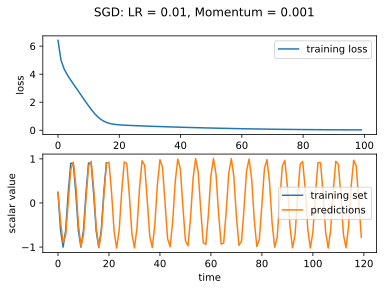

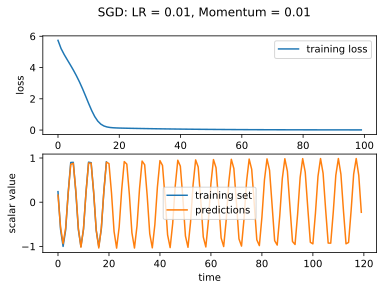

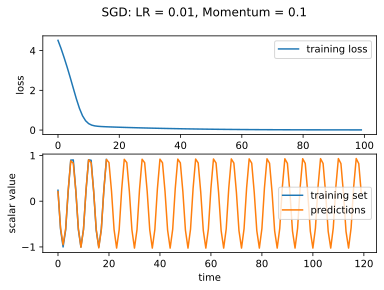

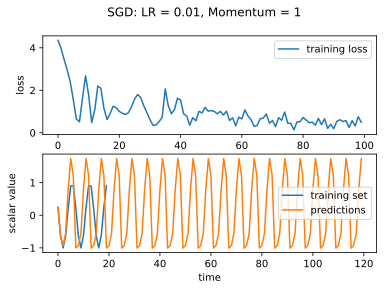

In [10]:
learning_rates = [0.01]
momentum = [0.0, 0.001, 0.01, 0.1, 1]
for lr in learning_rates:
    for mom in momentum:
        model = RNN(input_size, hidden_size, output_size).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom)
        losses = train_model(model, optimizer, epochs=100)
        plot_prediction(model, losses)

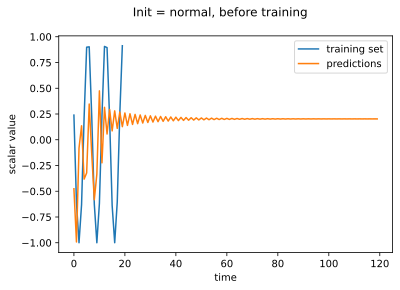

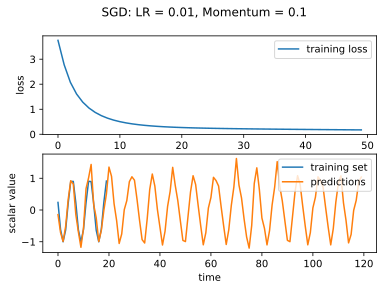

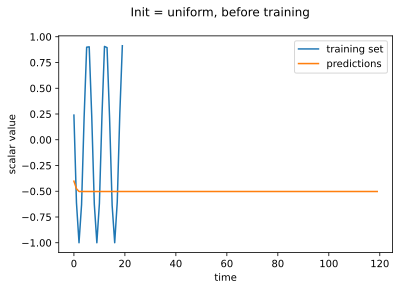

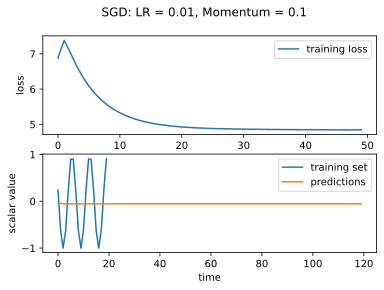

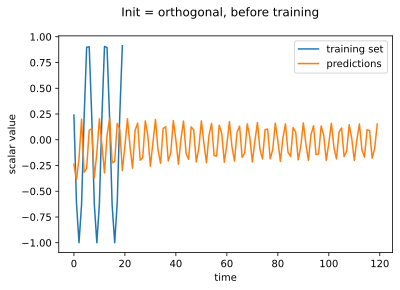

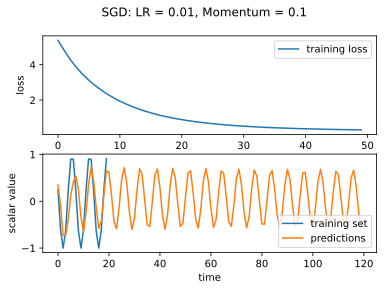

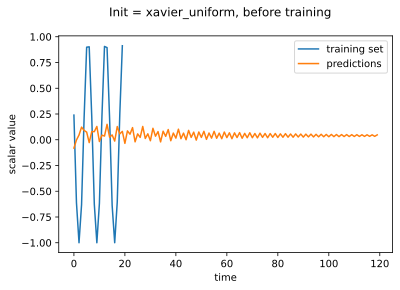

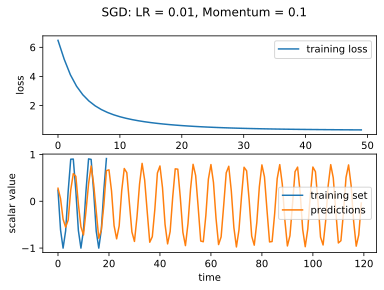

In [11]:
hidden_size = 10
lr = 0.01
mom = 0.1
initializations = ['normal', 'uniform', 'orthogonal', 'xavier_uniform']

for init in initializations:
    model = RNN(input_size, hidden_size, output_size, init=init).to(device)
    plot_prediction(model, losses, only_prediction=True)
    optimizer = optim.SGD(model.obs_model.parameters(), lr=lr, momentum=mom)
    losses = train_model(model, optimizer, epochs=50)
    plot_prediction(model, losses)